# "Quick look" plots
---
Make nice collage plots for a given set of galaxies, for use in papers/presentations/etc.

In [1]:
# Imports
import sys
import os 
import numpy as np
import pandas as pd
from astropy.visualization import hist
from astropy.io import fits

from spaxelsleuth.loaddata.sami import load_sami_galaxies
from spaxelsleuth.plotting.plot2dmap import plot2dmap
from spaxelsleuth.plotting.sdssimg import plot_sdss_image
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plottools import vmin_fn, vmax_fn, label_fn, cmap_fn, component_colours
from spaxelsleuth.plotting.plotgalaxies import plot2dscatter, plot2dhistcontours

import matplotlib
from matplotlib import rc, rcParams
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from IPython.core.debugger import Tracer

rc("text", usetex=False)
rc("font",**{"family": "serif", "size": 12})
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.format"] = "pdf"
plt.ion()
plt.close("all")

In [2]:
###########################################################################
# Paths
###########################################################################
sami_data_path = "/priv/meggs3/u5708159/SAMI/sami_dr3/"
sami_datacube_path = "/priv/myrtle1/sami/sami_data/Final_SAMI_data/cube/sami/dr3/"

In [67]:
###########################################################################
# Options
###########################################################################
fig_path = "/priv/meggs3/u5708159/SAMI/figs/"
savefigs = True
bin_type = "default"    # Options: "default" or "adaptive" for Voronoi binning
ncomponents = "recom"   # Options: "1" or "recom"
eline_SNR_min = 5       # Minimum S/N of emission lines to accept

In [4]:
###########################################################################
# Load the SAMI sample
###########################################################################
df_sami = load_sami_galaxies(ncomponents="recom",
                             bin_type="default",
                             eline_SNR_min=eline_SNR_min, 
                             vgrad_cut=False,
                             correct_extinction=False,
                             sigma_gas_SNR_cut=True)

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc,

In [5]:
###########################################################################
# Load the DataFrame containing S/N metadata
###########################################################################
# Load the SNR DataFrame.
df_snr = pd.read_csv(os.path.join(sami_data_path, "sample_summary.csv"))

# Sort by median red S/N in 2R_e
df_snr = df_snr.sort_values("Median SNR (R, 2R_e)", ascending=False)

# Set index to catid for ease of indexing
df_snr = df_snr.set_index("catid")

In [14]:
###########################################################################
# X, Y pixel coordinates for extracting an SDSS-like spectrum
###########################################################################
ys, xs = np.meshgrid(np.arange(50), np.arange(50), indexing="ij")
as_per_px = 0.5
ys_as = ys * as_per_px
xs_as = xs * as_per_px

# Centre galaxy coordinates (see p16 of Croom+2021)
x0_px = 25.5
y0_px = 25.5

# Create a mask 
mask = (xs - x0_px)**2 + (ys - y0_px)**2 <= 1.5**2
mask_area_px = len(mask[mask])
mask_area_arcsec2 = mask_area_px * as_per_px**2

In [15]:
###########################################################################
# Collage figure 1: coloured by number of components
###########################################################################
markers = ["o", ">", "D"]
l = 0.05
b = 0.05
dw = 0.05
dh = 0.1
w = (1 - 2 * l - 2 * dw) / 5
h = (1 - 2 * b - dh) / 2


In [29]:
etgs = df_snr.loc[df_snr["Morphology (numeric)"] == 0].index.values
etgs

array([    230776, 9011900073,     137838, 9403801368, 9403800035,
            55143,     371171, 9011900547, 9403800123,     279932,
           422406, 9403800184, 9011900024, 9011900001,      79810,
       9011900002, 9403800001,     227266, 9091700002, 9239900056,
            39057,      70114, 9239901179,     492411, 9016800001,
       9008500002,     184648, 9016800106, 9388000001,     230786,
           216184, 9239900138, 9008500829, 9403800002,     594049,
       9008500868,     323566, 9403800117, 9016800002,      56181,
       9011900006, 9011900430, 9008500001, 9011900254, 9239900010,
            99428,     422291,     551619,     492486, 9388000007,
            62244, 9388000200, 9239900067, 9016800275, 9403800168,
       9008500007, 9403800119,     136842, 9044200158,     618151,
           346837, 9239900108, 9011900074, 9008500138, 9008500042,
       9044200025, 9239900068,      70802,     505765, 9239900012,
       9016800156, 9044200001, 9016800197, 9091700001,     599

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/u5708159/python/Modules/spaxelsleuth/plotting/plot2dmap.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gal["x, y (pixels)"] = list(zip(df_gal["x (projected, arcsec)"] / as_per_px, df_gal["y (projected, arcsec)"] / as_per_px))
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: in

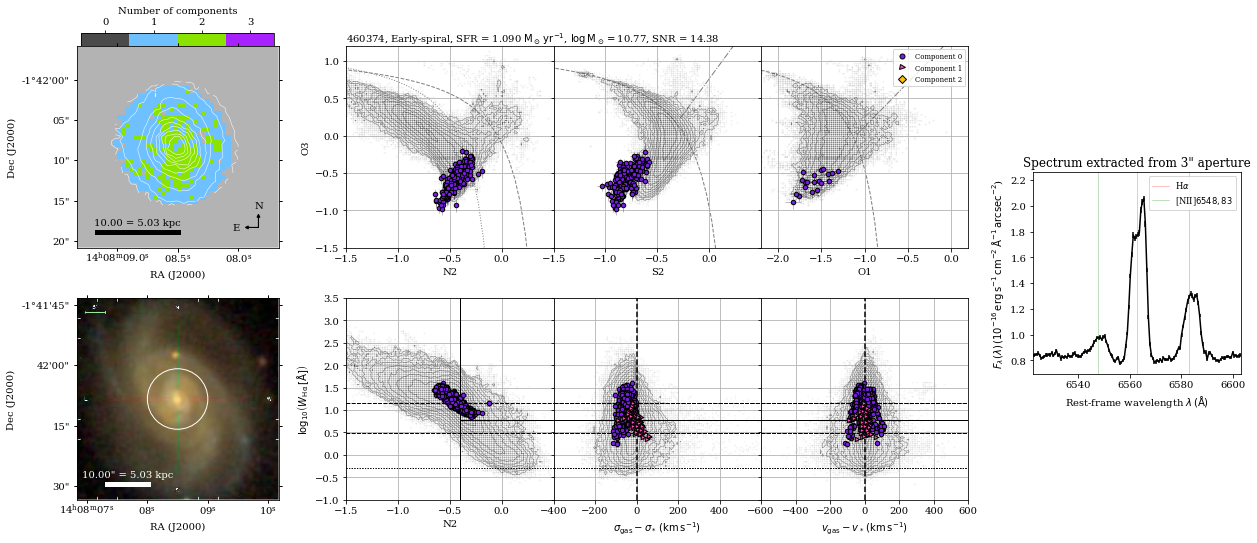

In [91]:
###########################################################################
# Define galaxy
###########################################################################
gal = 460374

# Check validity
assert gal in df_sami.catid, f"{gal} not found in SAMI sample!"

# Load the DataFrame
df_gal = df_sami[df_sami["catid"] == gal]
df_gal.loc[df_gal["Number of components"] == 0, "Number of components"] = np.nan

###########################################################################
# Create the figure
###########################################################################
fig_collage = plt.figure(figsize=(18, 7))
ax_sdss = fig_collage.add_axes([l, b, w, h])
ax_im = fig_collage.add_axes([l, b + h + dh, w, h])
bbox = ax_im.get_position()
cax_im = fig_collage.add_axes([bbox.x0 + bbox.width * 0.035, bbox.y0 + bbox.height, bbox.width * 0.93, 0.025])
axs_bpt = []
axs_bpt.append(fig_collage.add_axes([l + w + dw, b + h + dh, w, h]))
axs_bpt.append(fig_collage.add_axes([l + w + dw + w, b + h + dh, w, h]))
axs_bpt.append(fig_collage.add_axes([l + w + dw + 2 * w, b + h + dh, w, h]))
axs_whav = []
axs_whav.append(fig_collage.add_axes([l + w + dw, b, w, h]))
axs_whav.append(fig_collage.add_axes([l + w + dw + w, b, w, h]))
axs_whav.append(fig_collage.add_axes([l + w + dw + 2 * w, b, w, h]))
ax_spec = fig_collage.add_axes([l + w + dw + 3 * w + dw, (1 - h) / 2, w, h])

###########################################################################
# Plot SDSS image and component map
###########################################################################
col_z = "Number of components"

# SDSS image
res = plot_sdss_image(df_gal, ax=ax_sdss)
if res is None:
    ax_sdss.text(s="Galaxy not in SDSS footprint",
                 x=0.5, y=0.5, horizontalalignment="center",
                 transform=ax_sdss.transAxes)

# Plot the number of components fitted.
plot2dmap(df_gal=df_gal, bin_type="default", survey="sami",
          PA_deg=0,
          col_z=col_z, 
          ax=ax_im, cax=cax_im, cax_orientation="horizontal", show_title=False)

# Text string showing basic info
sfr = df_snr.loc[gal, 'SFR (component 0)']
mstar = df_gal["mstar"].unique()[0]
if np.isnan(sfr):
    sfr = "n/a"
else:
    sfr = f"{sfr:.3f}" + r" $\rm M_\odot\,yr^{-1}$"
    
if np.isnan(mstar):
    mstar = r"$\log \rm \, M_\odot = $ n/a"
else:
    mstar = r"$\log \rm \, M_\odot = $" + f"{mstar:.2f}"

t = axs_bpt[0].text(s=f"{gal}, {df_snr.loc[gal, 'Morphology']}, SFR = {sfr}, {mstar}, SNR = {df_snr.loc[gal, 'Median SNR (R, 2R_e)']:.2f}", 
    x=0.0, y=1.02, transform=axs_bpt[0].transAxes)

# Plot BPT diagram
col_y = "log O3"
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Plot full SAMI sample
    plot2dhistcontours(df=df_sami, 
                       col_x=f"{col_x} (total)",
                       col_y=f"{col_y} (total)", col_z="count", log_z=True,
                       alpha=0.5, cmap="gray_r",
                       ax=axs_bpt[cc], plot_colorbar=False)

    # Add BPT functions
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot measurements for this galaxy
    plot2dscatter(df=df_gal,
                  col_x=f"{col_x} (total)",
                  col_y=f"{col_y} (total)",
                  col_z=None if col_z == "Number of components" else col_z,
                  marker=markers[0], ax=axs_bpt[cc], 
                  cax=None,
                  markersize=20, 
                  markerfacecolor=component_colours[0] if col_z == "Number of components" else None, 
                  markeredgecolor="black",
                  plot_colorbar=False)

# Decorations
[ax.grid() for ax in axs_bpt]
[ax.set_ylabel("") for ax in axs_bpt[1:]]
[ax.set_yticklabels([]) for ax in axs_bpt[1:]]
[ax.set_xticks(ax.get_xticks()[:-1]) for ax in axs_bpt[:-1]]
for ax in axs_bpt:
    _ = [c.set_rasterized(True) for c in ax.collections]
_ = [c.set_rasterized(True) for c in ax_im.collections]

###########################################################################
# Plot WHAN, WHAV and WHAV* diagrams.
###########################################################################
# Plot LZIFU measurements
for cc, col_x in enumerate(["log N2", "sigma_gas - sigma_*", "v_gas - v_*"]):
    # Plot full SAMI sample
    plot2dhistcontours(df=df_sami, 
                       col_x=f"{col_x} (total)" if col_x == "log N2" else f"{col_x}",
                       col_y=f"log HALPHA EW (total)" if col_x == "log N2" else f"log HALPHA EW",
                       col_z="count", log_z=True,
                       alpha=0.5, cmap="gray_r", ax=axs_whav[cc],
                       plot_colorbar=False)

# WHAN diagram
plot2dscatter(df=df_gal,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z=None if col_z == "Number of components" else col_z,
              marker=markers[0], ax=axs_whav[0], 
              cax=None,
              markersize=20, 
              markerfacecolor=component_colours[0] if col_z == "Number of components" else None, 
              markeredgecolor="black",
              plot_colorbar=False)

# Kinematics 
for cc, col_x in enumerate(["sigma_gas - sigma_*", "v_gas - v_*"]):
    # Plot the data for this galaxy
    for ii in range(3):
        plot2dscatter(df=df_gal,
                      col_x=f"{col_x} (component {ii})",
                      col_y=f"log HALPHA EW (component {ii})",
                      col_z=None if col_z == "Number of components" else col_z,
                      marker=markers[ii], ax=axs_whav[cc + 1], 
                      cax=None,
                      markersize=20, 
                      markerfacecolor=component_colours[ii] if col_z == "Number of components" else None, 
                      markeredgecolor="black",
                      plot_colorbar=False)

# Decorations
[ax.grid() for ax in axs_whav]
[ax.set_ylabel("") for ax in axs_whav[1:]]
[ax.set_yticklabels([]) for ax in axs_whav[1:]]
[ax.set_xticks(ax.get_xticks()[:-1]) for ax in axs_whav[:-1]]
[ax.axvline(0, ls="--", color="k") for ax in axs_whav[1:]]
for ax in axs_whav:
    _ = [c.set_rasterized(True) for c in ax.collections]

# Legend
legend_elements = [Line2D([0], [0], marker=markers[ii], 
                          color="none", markeredgecolor="black",
                          label=f"Component {ii}",
                          markerfacecolor=component_colours[ii], markersize=5) for ii in range(3)]
axs_bpt[-1].legend(handles=legend_elements, fontsize="x-small", loc="upper right")

###########################################################################
# Extract the spectrum from the red data cube 
###########################################################################
hdulist_R_cube = fits.open(os.path.join(sami_datacube_path, f"ifs/{gal}/{gal}_A_cube_red.fits.gz"))
header = hdulist_R_cube[0].header
data_cube_R = hdulist_R_cube[0].data
var_cube_R = hdulist_R_cube[1].data

# Get wavelength values 
z = df_snr.loc[gal, "z_spec"]
lambda_0_A = header["CRVAL3"] - header["CRPIX3"] * header["CDELT3"]
dlambda_A = header["CDELT3"]
N_lambda = header["NAXIS3"]
lambda_vals_A = np.array(range(N_lambda)) * dlambda_A + lambda_0_A 
lambda_rest_A = lambda_vals_A / (1 + z)

# Extract spectrum
spec = np.nansum(data_cube_R[:, mask], axis=1)
spec_err = np.sqrt(np.nansum(var_cube_R[:, mask], axis=1))
start = np.nanargmin(np.abs(lambda_rest_A - (6562.8 - 40)))
stop = np.nanargmin(np.abs(lambda_rest_A - (6562.8 + 40)))

# Divide by pixel area in arcsec2
spec /= mask_area_arcsec2
spec_err /= mask_area_arcsec2

# Plot 
ax_spec.errorbar(x=lambda_rest_A, y=spec, yerr=spec_err, color="k")
ax_spec.set_xlim([(6562.8 - 40), (6562.8 + 40)])
ax_spec.set_ylim([0.9 * np.nanmin(spec[start:stop]), 1.1 * np.nanmax(spec[start:stop])])
ax_spec.axvline(6562.8, color="r", alpha=0.5, lw=0.5, label=r"H$\alpha$")
ax_spec.axvline(6548, color="g", alpha=0.5, lw=0.5, label=r"[NII]$6548,83$")
ax_spec.axvline(6583, color="g", alpha=0.5, lw=0.5)
ax_spec.set_xlabel(r"Rest-frame wavelength $\lambda \,\rm (\AA)$")
ax_spec.set_ylabel(r"$F_\lambda(\lambda)\,\rm (10^{-16} \, erg \, s^{-1} \, cm^{-2} \, \AA^{-1} \, arcsec^{-2}$)")
ax_spec.legend(loc="upper right", fontsize="small")
ax_spec.set_title("Spectrum extracted from 3\" aperture")

###########################################################################
# Save 
###########################################################################
if savefigs:
    fname = "spec" if col_z == "Number of components" else "radius"
    fig_collage.savefig(os.path.join(fig_path, f"{gal}_SAMI_summary_{fname}.pdf"), format="pdf", bbox_inches="tight")
